In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8
def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [2]:
coins = pd.read_parquet("../data/coins_df.parquet")

In [3]:
coins.head(5)

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasIssuer,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after
0,http://numismatics.org/ocre/id/ric.6.sis.221,"[http://www.w3.org/2004/02/skos/core#Concept, ...",licinius,ae2,0311-01-01,struck,ae,siscia,ric.6.sis.221#obverse,pannonia,...,,DIVO GAL VAL MAXIMIANO,galerius,"Head of Galerius, veiled, right",FORTI FOR-TVNAE,58260,"Fortuna, draped, standing left by wheel, holdi...",None,311.0,311.0
1,http://numismatics.org/ocre/id/ric.4.ph_i.28A,"[http://www.w3.org/2004/02/skos/core#Concept, ...",philip_the_arab,aureus,0247-01-01,struck,av,rome,ric.4.ph_i.28A#obverse,italy,...,,IMP M IVL PHILIPPVS AVG,philip_the_arab,"Bust of Philip the Arab, laureate, draped, cui...",ANNONA AVGG,nomisma.rdf,"Annona, draped, standing left, holding corn-ea...",None,244.0,247.0
2,http://numismatics.org/ocre/id/ric.9.tri.96B.2,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valentinian_ii,ae3,0392-01-01,struck,ae,treveri,ric.9.tri.96B.2#obverse,gallia,...,,D N THEODO-SIVS P F AVG,theodosius_i,"Bust of Theodosius I, pearl-diademed, draped a...",GLORIA RO-MANORVM,,"Emperor advancing right, dragging captive with...",None,388.0,392.0
3,http://numismatics.org/ocre/id/ric.8.aq.3,"[http://www.w3.org/2004/02/skos/core#Concept, ...",constantine_ii,multiple-gold,0340-01-01,struck,av,aquileia,ric.8.aq.3#obverse,italy,...,,FL IVL CONS-TANS P F AVG,constans,"Bust of Constans, laureate, rosette-diademed, ...",VIRTVS - CONSTANTIS AVG,constans,"Constans, draped, cuirassed, standing front, h...",None,337.0,340.0
4,http://numismatics.org/ocre/id/ric.4.crl.191,"[http://www.w3.org/2004/02/skos/core#Concept, ...",caracalla,denarius,0211-01-01,struck,ar,rome,ric.4.crl.191#obverse,italy,...,,ANTONINVS PIVS AVG BRIT,caracalla,"Head of Caracalla, laureate, right",PONTIF TR P XIIII COS III,80685,"Virtus, helmeted, draped, standing right, left...",None,211.0,211.0


In [4]:
coins["date_avr"] = coins.apply(lambda row: (row["not_before"] + row["not_after"]) / 2, axis=1).round()

<AxesSubplot:xlabel='date_avr', ylabel='Density'>

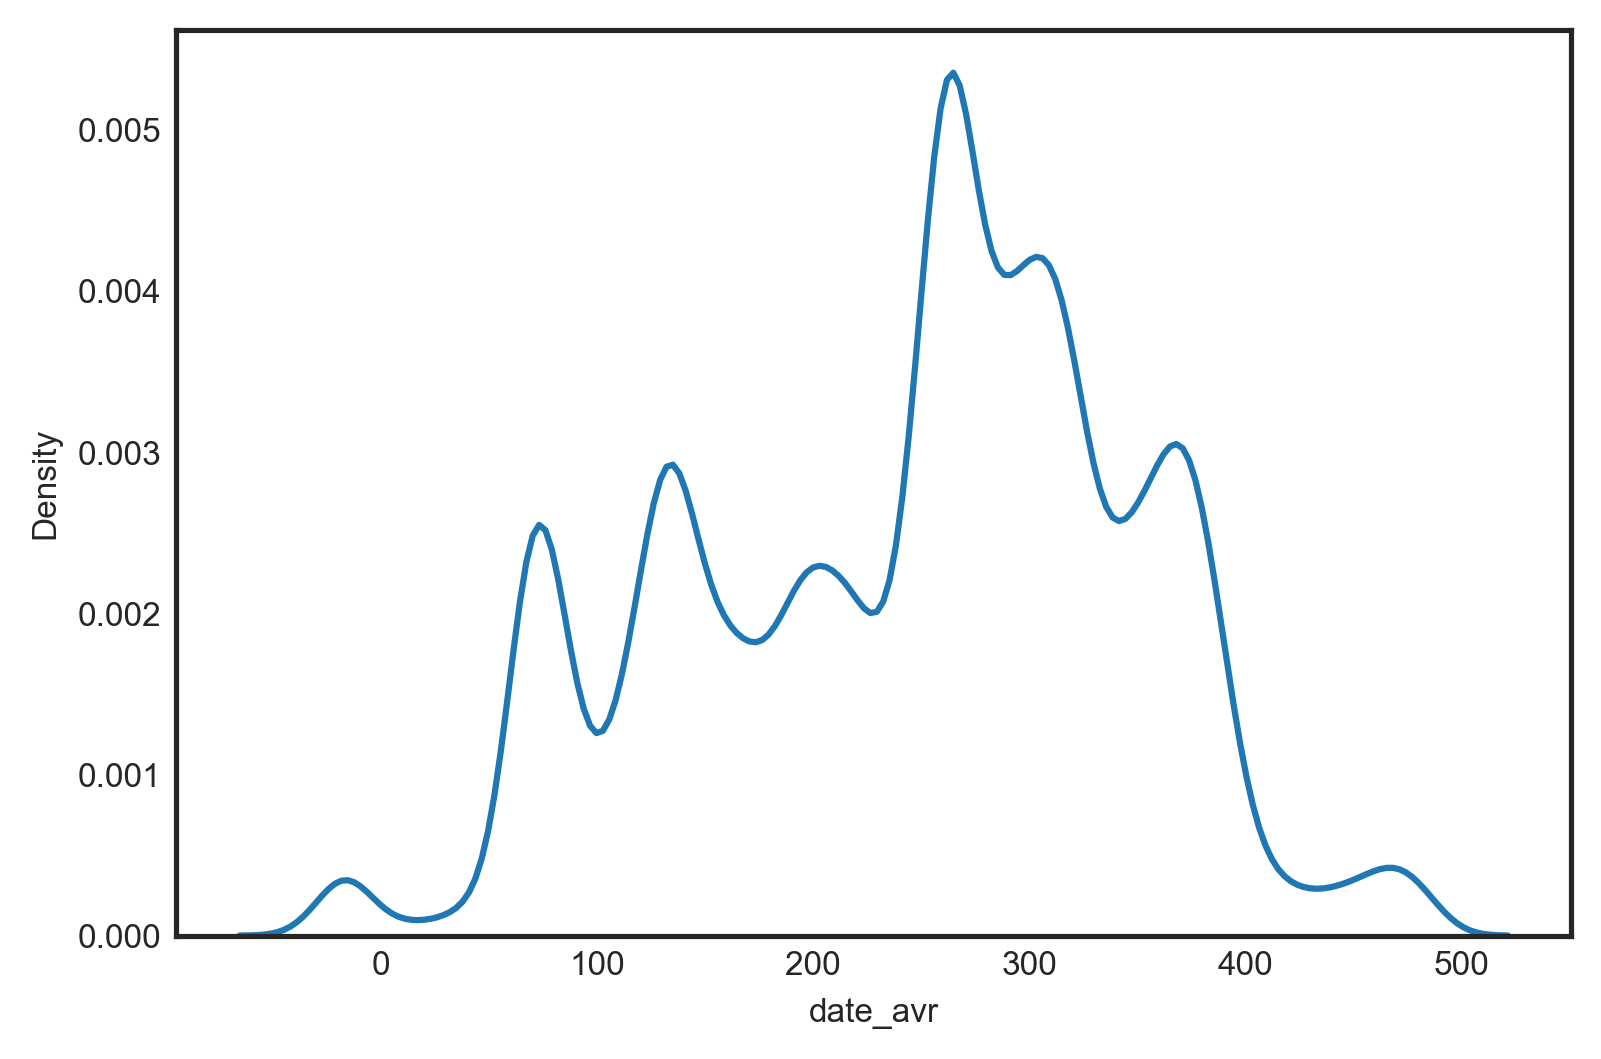

In [11]:
sns.kdeplot(coins["date_avr"])

In [12]:
test_dates = coins["date_avr"].tolist()[:1000]
test_dates

[311.0,
 246.0,
 390.0,
 338.0,
 211.0,
 313.0,
 80.0,
 290.0,
 310.0,
 272.0,
 380.0,
 193.0,
 334.0,
 279.0,
 366.0,
 137.0,
 318.0,
 164.0,
 108.0,
 318.0,
 298.0,
 184.0,
 206.0,
 334.0,
 264.0,
 439.0,
 216.0,
 117.0,
 302.0,
 196.0,
 446.0,
 73.0,
 138.0,
 142.0,
 312.0,
 376.0,
 371.0,
 298.0,
 238.0,
 122.0,
 322.0,
 342.0,
 371.0,
 264.0,
 218.0,
 250.0,
 306.0,
 371.0,
 107.0,
 258.0,
 -4.0,
 81.0,
 107.0,
 264.0,
 274.0,
 358.0,
 -4.0,
 354.0,
 -16.0,
 282.0,
 250.0,
 310.0,
 142.0,
 340.0,
 194.0,
 279.0,
 317.0,
 264.0,
 390.0,
 68.0,
 276.0,
 238.0,
 289.0,
 68.0,
 -12.0,
 1.0,
 216.0,
 371.0,
 324.0,
 136.0,
 264.0,
 264.0,
 137.0,
 258.0,
 316.0,
 290.0,
 214.0,
 297.0,
 324.0,
 264.0,
 338.0,
 371.0,
 264.0,
 317.0,
 194.0,
 386.0,
 -19.0,
 366.0,
 207.0,
 184.0,
 257.0,
 366.0,
 174.0,
 294.0,
 300.0,
 350.0,
 290.0,
 132.0,
 394.0,
 237.0,
 296.0,
 71.0,
 206.0,
 137.0,
 231.0,
 282.0,
 217.0,
 276.0,
 309.0,
 206.0,
 349.0,
 358.0,
 142.0,
 371.0,
 164.0,
 154.0,
 1

In [13]:
n = 246

In [14]:
[d for d in test_dates if n-5 <= d <= n+5]

[246.0,
 250.0,
 250.0,
 244.0,
 249.0,
 248.0,
 249.0,
 250.0,
 250.0,
 251.0,
 251.0,
 250.0,
 249.0,
 241.0,
 246.0,
 246.0,
 242.0,
 250.0,
 248.0,
 246.0,
 243.0,
 247.0,
 251.0,
 251.0,
 246.0,
 250.0,
 248.0,
 246.0,
 245.0,
 246.0,
 245.0,
 246.0,
 248.0,
 249.0]

In [15]:
def get_moving_avr(dates_data, buffer=10):
    diff = int(buffer / 2)
    dates_data = list(dates_data)
    date_min = int(np.nanmin(dates_data))
    date_max = int(np.nanmax(dates_data))
    #return date_max
    dates = [n for n in range(date_min + diff, date_max - diff)]
    counts = []
    for n in dates:
        counts.append((len([d for d in dates_data if n-diff <= d <= n+diff])))
    return dates, counts

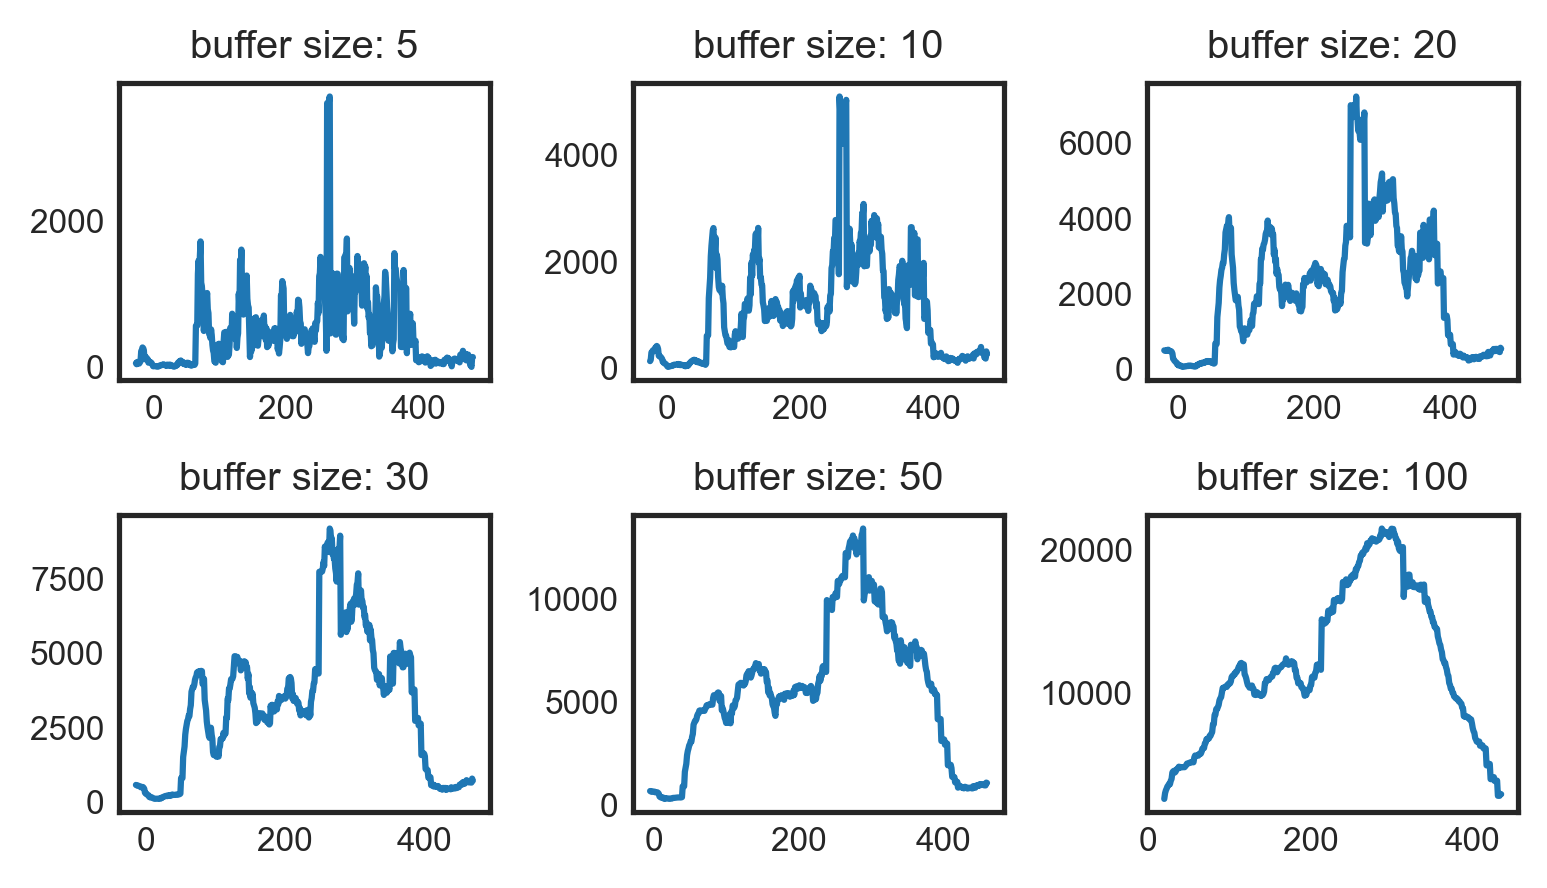

In [18]:
buffer_sizes = [5, 10, 20, 30, 50, 100]

fig, axs = plt.subplots(2,3, figsize=(5.2, 3), dpi=300, tight_layout=True)
for buffer, ax in zip(buffer_sizes, axs.ravel()):
    moving_avr_data = get_moving_avr(coins["date_avr"], buffer)
    ax.plot(moving_avr_data[0], moving_avr_data[1])
    ax.set_title("buffer size: " + str(buffer))

In [20]:
len(coins)

51311

In [29]:
coins.groupby("ontology#hasDenomination").size()

ontology#hasDenomination
                    337
12-as                 1
2-solidus            38
24-as                 2
3-solidus             7
                   ... 
small_ae2           162
solidus            2079
tremissis           289
triens                2
uncertain_value     463
Length: 3117, dtype: int64

In [21]:
len(coins[coins["ontology#hasDenomination"].str.contains("denarius")])

6986

In [32]:
coins[coins["ontology#hasDenomination"].str.contains("denarius")].groupby("ontology#hasDenomination").size()

ontology#hasDenomination
4-denarius       1
5-denarius       2
8-denarius       1
denarius      6982
dtype: int64

In [45]:
authorities_all_coins = coins.groupby("ontology#hasAuthority").size().sort_values(ascending=False)
authorities_all_coins

ontology#hasAuthority
gallienus         4184
constantine_i     4022
hadrian           3577
antoninus_pius    2381
maximian          2324
                  ... 
aureolus             2
odoacer              2
zenobia              2
domitian_ii          1
saturninus           1
Length: 130, dtype: int64

In [46]:
authorities_denarius = coins[coins["ontology#hasDenomination"].str.contains("denarius")].groupby("ontology#hasAuthority").size().sort_values(ascending=False)
authorities_denarius

ontology#hasAuthority
hadrian                       1237
septimius_severus              864
antoninus_pius                 546
marcus_aurelius                514
trajan                         341
severus_alexander              341
vespasian                      330
domitian                       293
augustus                       281
caracalla                      281
commodus                       274
elagabalus                     247
pescennius_niger               187
galba                          152
anonymous                      126
carausius                      104
macrinus                        98
clodius_albinus                 79
titus                           76
geta                            60
vitellius                       58
nerva                           47
clodius_macer                   42
gallienus                       41
maximinus_thrax                 38
claudius                        38
nero                            37
postumus                        3

In [49]:
authorities_denarius_dict = dict(authorities_denarius)
authorities_all_coins_dict = dict(authorities_all_coins)

In [53]:
xs, ys = [], []
for au in authorities_denarius_dict.keys():
    xs.append(authorities_denarius_dict[au])
    ys.append(authorities_all_coins_dict[au])

<AxesSubplot:>

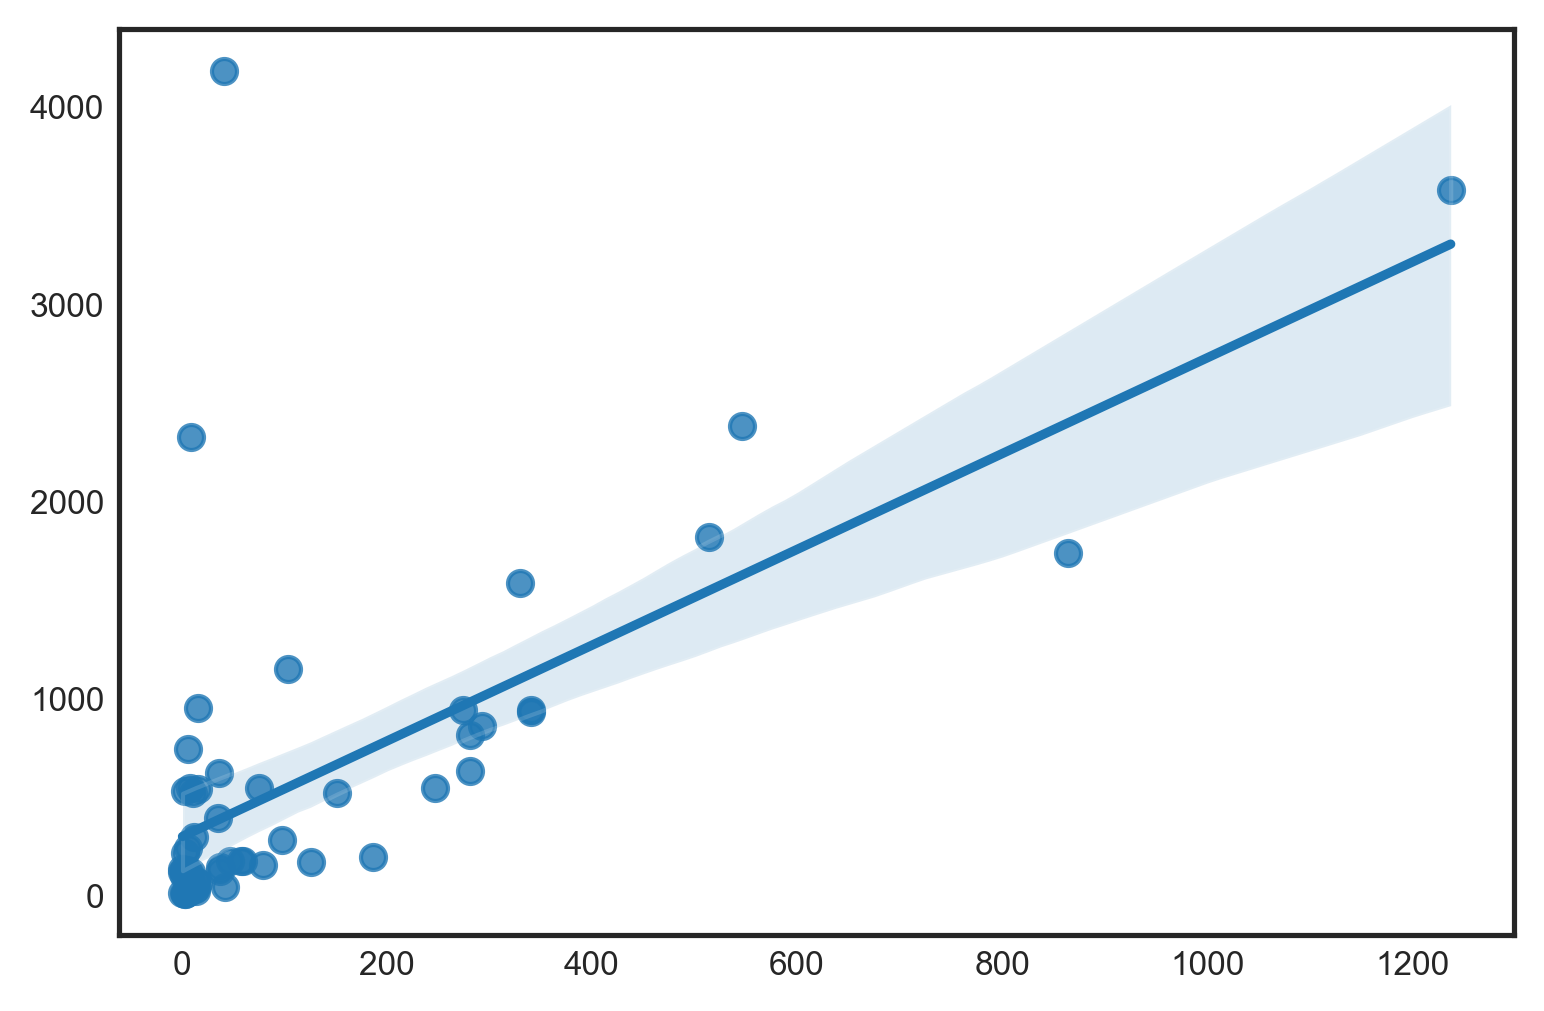

In [74]:
sns.regplot(x=xs, y=ys)